# Lag Time Analysis 5: Compare xcorr analyses
The values above determine what sort of analysis will be performed.

In [1]:
# Parameters
analysis_tag = "band7d3d"
analysis_plotting = False
analysis_data_source = "WBdata-depth.parquet"
analysis_data_source_label = "Depth (m)"
analysis_missing = "full"
analysis_transform = "filter"
analysis_filter_type = "bandpass"
analysis_filter_cutoff = ["7 day", "3 day"]
analysis_levels = [0, 1, 2, 3, 4, 5, 6, 7]
analysis_search_window = "full"
analysis_detrend = False


## Modify four aspects of this procedure to improve performance: 
- STEP 1 - Data source:
    - stream depth (modified from stage)
    - stream discharge
- STEP 2 - Dealing with missing data: 
    - replace missing values with linear interpolation
    - drop missing values
- STEP 3 - Using raw vs. transformed data
    - raw data (no transformation)
    - differenced data (subtract Qi from Qi+1)
    - filtered data (long pass, band pass of various lengths)
- STEP 4 - Split data into shorter segments
    - each 'level' is a factor of two shorter
- STEP 5 - Set Cross-correlation parameters
    - accept all xcorr matches, or only accept within a window


# Preparation

## Imports

In [2]:
%matplotlib inline

import pandas as pd
from pandas.tseries.frequencies import to_offset as pandas_to_offset
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

from scipy.signal import detrend as sig_detrend

import analysis_functions as my

my.print_versions()

Package Versions
----------------
Python: 3.10.16
numpy: 1.26.4
pandas: 2.2.3
scipy: 1.15.1
statsmodels: 0.14.4
pangoin: not imported
matplotlib: 3.10.0
seaborn: 0.13.2
hydrofunctions: 0.2.4
analysis_funtions: 2025.06.27


## Read Data
The data comes from `data_source`

In [3]:
# This dictionary contains all of the parameters for this run
# The values were set in 'LTA_5_XCorr-Execute_Papermill.ipynb', which injected them in the very first cell, above.
# Every time that page is run, the session will be recorded by this page into 'sessions.parquet'.
analysis_start_time = pd.Timestamp.now(tz='utc')
parameters = {
    'analysis_tag': analysis_tag,
    'analysis_start': analysis_start_time.strftime('%Y-%m-%dT%H:%M:%SZ'),
    'analysis_stop': None,
    'analysis_runtime': None,
    'analysis_filename': None,
    'analysis_plotting': analysis_plotting,
    'analysis_data_source': analysis_data_source,
    'analysis_data_source_label': analysis_data_source_label,
    'analysis_missing': analysis_missing,
    'analysis_transform': analysis_transform,
    'analysis_filter_type': analysis_filter_type,
    'analysis_filter_cutoff': analysis_filter_cutoff,
    'analysis_levels': analysis_levels,
    'analysis_search_window': analysis_search_window,
    'analysis_detrend': analysis_detrend,
}

In [4]:
#analysis_data_source = 'WBdata-discharge.parquet'
print(f"Loading data from {analysis_data_source}")
data = pd.read_parquet(analysis_data_source)

# List the first five records. Note that the data are collected every 15 minutes and show discharge in m³/s for each of the four stations.
print(f'First observation: {data.index.min()}')
print(f'Last observation:  {data.index.max()}')
print(f'Length: {data.index.max()-data.index.min()}')
print(f'{data.shape} records')
print(f'Missing: {data.isna().sum()}')
clean_data = data.interpolate()
print(f'Missing after interpolation: {clean_data.isna().sum()}')
clean_data.head()

Loading data from WBdata-depth.parquet


First observation: 2012-10-01 04:00:00+00:00
Last observation:  2016-10-02 03:45:00+00:00
Length: 1461 days 23:45:00
(140352, 5) records
Missing: 01541200    265
01541303     41
01542500      5
01545500     56
01551500     50
dtype: int64
Missing after interpolation: 01541200    0
01541303    0
01542500    0
01545500    0
01551500    0
dtype: int64


,01541200,01541303,01542500,01545500,01551500
datetimeUTC,,,,,
2012-10-01 04:00:00+00:00,0.514547,0.345172,0.571084,0.730550,0.992743
2012-10-01 04:15:00+00:00,0.517595,0.345172,0.571084,0.730550,0.992743
2012-10-01 04:30:00+00:00,0.514547,0.345172,0.571084,0.724454,0.995791
2012-10-01 04:45:00+00:00,0.514547,0.345172,0.568036,0.724454,0.995791
2012-10-01 05:00:00+00:00,0.514547,0.345172,0.568036,0.721406,0.995791


In [5]:
# Load stations & reach data
stations = pd.read_parquet('stations.parquet') # location of stations on the WB Susquehanna
reaches = pd.read_parquet('reaches.parquet')  # Length of different reaches

#Read validation data
# Validation data. Tables are organized: rows-wave; columns-site or reach.
val_celerity = pd.read_parquet('validation_celerity-table.parquet')
val_time = pd.read_parquet('validation_times-table.parquet')
val_depth = pd.read_parquet('validation_depths-table.parquet')

validation = pd.read_parquet('validation_reaches.parquet') # Organized as records

In [6]:
reaches

,us,ds,length,head,gradient,deltaQ,deltaA,symbol,color
Curwensville-Hyde,01541200,01541303,13034,9.309905,0.000714,1.423295,1.291272,+,#2f9df5
Hyde-Karthaus,01541303,01542500,71700,80.918664,0.001129,2.834331,3.083876,x,#4df884
Karthaus-Renovo,01542500,01545500,55524,60.320890,0.001086,2.105634,2.034592,*,#dedd32
Renovo-Williamsport,01545500,01551500,93772,42.537953,0.000454,1.913043,1.909929,o,#f65f18


## Transform Dataset
If the data will be transformed, then nans will be replaced through linear interpolation first to prevent edge effects.
If the missing data policy is to NOT replace missing data, then the transformed values will be replaced again with Nans.



In [7]:
print(f"Transforming the dataset using the method: {analysis_transform}")

if analysis_transform == 'no_transform':
    print("No transformation will take place.")
    transform_data = clean_data
elif analysis_transform == 'filter':
    # Create a new dataset that has been filtered with a second-order butterworth bandpass filter; run xcorr on this.
    print(f"The filter type is: {analysis_filter_type}")
    print(f"The filter cutoff is: {analysis_filter_cutoff}")
    transform_data = my.butterworth(clean_data, cutoff=analysis_filter_cutoff, sample_period='15 minutes', order=2, filter_type=analysis_filter_type) 
elif analysis_transform == 'difference':
    print("Using a difference filter to transform data.")
    transform_data = clean_data.diff().bfill()
elif analysis_transform == 'smooth-difference':
    smooth_data = my.butterworth(clean_data, cutoff=analysis_filter_cutoff, sample_period='15 minutes', order=2, filter_type='lowpass')
    transform_data = smooth_data.diff().bfill()
else:
    raise ValueError(f"This transform method is not recognized. transform = {analysis_transform}")

missing = transform_data.isna().sum()
print(f'Missing after interpolation: {missing}')
if missing.sum() > 0:
    raise RuntimeError(f"The transformed data contains NaNs. {missing}")

transform_data.head()

Transforming the dataset using the method: filter
The filter type is: bandpass
The filter cutoff is: ['7 day', '3 day']
Missing after interpolation: 01541200    0
01541303    0
01542500    0
01545500    0
01551500    0
dtype: int64


,01541200,01541303,01542500,01545500,01551500
datetimeUTC,,,,,
2012-10-01 04:00:00+00:00,0.000665,-0.003010,0.006963,0.015521,0.008370
2012-10-01 04:15:00+00:00,0.000821,-0.002947,0.006712,0.015219,0.008614
2012-10-01 04:30:00+00:00,0.000979,-0.002881,0.006459,0.014912,0.008857
2012-10-01 04:45:00+00:00,0.001137,-0.002815,0.006203,0.014602,0.009100
2012-10-01 05:00:00+00:00,0.001297,-0.002746,0.005945,0.014289,0.009341


<Axes: xlabel='datetimeUTC'>

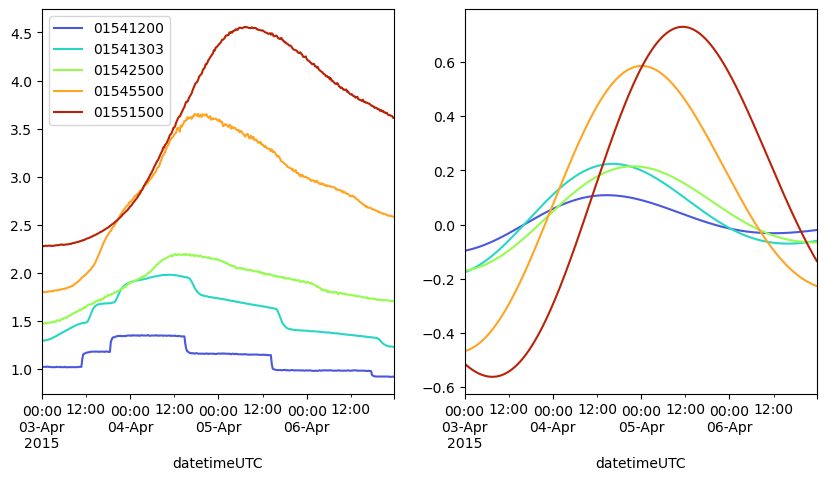

In [8]:
%matplotlib inline
# Plot three days of transformed data so we can see what it looks like transformed
fig, (axL, axR) = plt.subplots(ncols=2,figsize=(10, 5), sharex=True)
start = '2015-04-03'
stop = '2015-04-06'
data.loc[start:stop].plot(ax=axL, color=stations['color'])
transform_data.loc[start:stop].plot(ax=axR, color=stations['color'],legend=False)

<Axes: xlabel='datetimeUTC'>

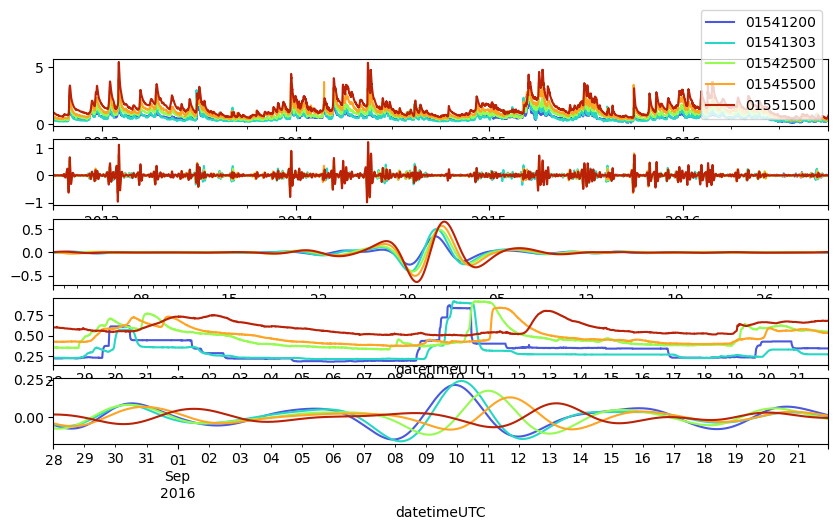

In [9]:
%matplotlib inline
# Plot three days of transformed data so we can see what it looks like transformed
fig, (A,B,C,D,E) = plt.subplots(nrows=5,figsize=(10, 5), sharex=False)

data.plot(ax=A, color=stations['color'])
transform_data.plot(ax=B, color=stations['color'],legend=False)
transform_data.loc['2011-09-30':'2012-11-30'].plot(ax=C, color=stations['color'],legend=False)

%matplotlib inline
start = '2016-08-28'
stop = '2016-09-21'
data.loc[start:stop].plot(ax=D, color=stations['color'],legend=False)
transform_data.loc[start:stop].plot(ax=E, color=stations['color'],legend=False)

In [10]:
def length_analysis2(data, upstream, downstream, level, length = None, reach=None, raw_data_label=None, raw_data=None, detrend=False, window=900):
    """Calculate the lag and cross-correlation for a dataset that has been broken into 2^level number of segments.
    
    The purpose of this function is to see how long of a data sequence is needed to produce lags of acceptable quality.
    It will split a dataset into smaller pieces, run xcorr on them, and then record the lag with the best correlation
    into a list, with each element of the list corresponding to one of the pieces of the original dataset.
    
    Inputs:
    =======
    
        data: a dataframe with labelled columns
        upstream: a selection label for a column in data. data[upstream] 
        downstream: the selection label for the downstream station column.
        level: the number of segments that data will be split into, number of segments = 2^level
        length: the distance in meters between the upstream and downstream stations.
        reach: the index value for the reach
        raw_data_label: (str) string to be used as the Y-axis label on plot of the raw data.
        raw_data: If data is transformed for analysis, then this is a dataframe with the untransformed values.
        window: either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        replace_nans: policy for how to replace nans. Uses the options for replace_na()
        plotting (default: True): If true, plot the data in the output.
    
    Returns:
    ========
        Will return 'results', a list of dicts, each dict containing stats about a segment of the data.
        Warning: the US_
    """

    
    if (data.index.freq is None):
        data.index.freq = pd.to_timedelta(pandas_to_offset(pd.infer_freq(data.index)))
        print("new freq: ", data.index.freq)

    num_of_segments = pow(2, level)
    segments = np.array_split(data, num_of_segments)
    seg_length = len(segments[0])
    results = []
    print(f"Analysis from site {upstream} to {downstream} in {num_of_segments} parts; segment length: {seg_length} ({pd.Timedelta('15 minutes') * seg_length})")
    for i, segment_df in enumerate(segments):
        print("\n\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"RUN {i} ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        us_df = segment_df[upstream]
        ds_df = segment_df[downstream]

        start = segment_df.index.min() # The start time for this segment.
        stop = segment_df.index.max() # The end time for this segment.
        if raw_data is not None:
            US_nulls = raw_data.loc[start:stop, upstream].isna().sum()
            DS_nulls = raw_data.loc[start:stop, downstream].isna().sum()
        else:
            US_nulls = data.loc[start:stop, upstream].isna().sum()
            DS_nulls = data.loc[start:stop, downstream].isna().sum()
        us_data_max = us_df.max()
        us_data_mean = us_df.mean()
        ds_data_max = ds_df.max()
        ds_data_mean = ds_df.mean()
        old_lag = np.nan
        comments = ""

        # Normalize segment
        us_df = us_df - us_data_mean
        ds_df = ds_df - ds_data_mean

        # Detrend segment
        if detrend == True:
            try:
                #us_df = us_df.interpolate()
                us_df = pd.Series(sig_detrend(us_df), index=segment_df.index) # Keep the same index pd.Series(detrend, 
                us_df.name = f"{upstream}-detrended"
                #ds_df = ds_df.interpolate()
                ds_df = pd.Series(sig_detrend(ds_df), index=segment_df.index)
                ds_df.name = f"{downstream}-detrended"
            except Exception as e:
                print('Error during detrending.')
                print(f"Level: {level}   Segment: {i}   US:{upstream}  DS:{downstream}")
                print(f"missing US values before detrending: {us_df.isna().sum()}")
                print(f"missing DS values before detrending: {ds_df.isna().sum()}")
                print(e)
                raise


        lags, ccor, ccov = my.xcorr_calc(us_df, ds_df)

        # clip the lags & ccor arrays to the window and send to get stats.
        if isinstance(window, int):
            ccor = ccor[lags < window]
            lags = lags[lags < window]
            if len(ccor) < 10 or len(lags) < 10:
                raise RuntimeError(f"After windowing, the length of the lag array and ccov array are too small. len(lags): {len(lags)}  len(ccov): {len(ccov)}")           
            if len(ccor) != len(lags):
                raise RuntimeError(f"After windowing, the length of the lag array and ccov array are different. len(lags): {len(lags)}  len(ccov): {len(ccov)}")
        
        # If the max lag is less than 1, handle it.
        segment_stats = my.xcorr_stats(lags, ccor)
        lag = segment_stats['ccor_max_lag']
        if lag < 0:  # If lag is less than 0, clip the array and try again.
            comments = comments + f"Lag was {lag}. "
            old_lag = lag
            ccor = ccor[lags >= 0]
            lags = lags[lags >= 0]
            segment_stats = my.xcorr_stats(lags, ccor)
            lag = segment_stats['ccor_max_lag']
        
        if lag == 0:
            celerity = np.nan
        else:
            celerity = length / (lag * 15 * 60)

        xc = segment_stats['ccor_max']
        xwidth = segment_stats['1st_0_lag']        
        
        result = {'us': upstream, 'ds': downstream, 'reach': reach, 'level': level, 'segment': i, 
                  'US_nulls': US_nulls, 'DS_nulls': DS_nulls, 'start': start, 'stop': stop, 
                  #'us_data_max': us_data_max, 'us_data_mean': us_data_mean, 
                  #'ds_data_max': ds_data_max, 'ds_data_mean': ds_data_mean,
                  #'us_idxmax': us_idxmax, 'ds_idxmax': ds_idxmax, 'lagmax': lagmax,
                  'lag': lag, 'xcorr': xc, 'xwidth': xwidth, 'celerity': celerity,
                  #'raw_us_data_max': raw_data.loc[start:stop, upstream].max(),
                  #'raw_ds_data_max': raw_data.loc[start:stop, downstream].max(),
                  'raw_us_data_mean': raw_data.loc[start:stop, upstream].mean(),
                  'raw_ds_data_mean': raw_data.loc[start:stop, downstream].mean(),
                  'comments': comments,
                  'old_lag': old_lag,
                 }
        results.append(result)
        print(result)
  
    
    return results

# Cross-Correlation Analysis
Calculate celerity for all four reaches using cross-correlation
run cross-correlation on small chunks of data


In [11]:
#papermill_description=Start_Cross_Correlation
%matplotlib inline

# Set up the analysis by creating a list to hold the results and setting the two stations I'll use for the analysis.
results = []

for level in analysis_levels:
    my.markdown(f"## Level {level}")
    print('*************************************************************')
    print(f'**   Starting Level  {level}                                     **')
    print('*************************************************************\n')
    for reach in reaches.index:
        reach_results = []
        US = reaches.loc[reach, 'us']
        DS = reaches.loc[reach, 'ds']
        length = reaches.loc[reach, 'length']
        print('         ============================================================================')
        print(f'             Starting Level {level}  Reach {reach} => US: {US}   DS: {DS}')
        print('         ============================================================================\n')
        reach_results = length_analysis2(
            transform_data, 
            US, 
            DS, 
            level=level,
            length=length, 
            reach=reach, 
            raw_data_label=analysis_data_source_label,
            raw_data=data, 
            detrend=analysis_detrend,
            window=analysis_search_window
        )
        results = results + reach_results
        print(reach_results)

## Level 0

*************************************************************
**   Starting Level  0                                     **
*************************************************************

             Starting Level 0  Reach Curwensville-Hyde => US: 01541200   DS: 01541303

new freq:  <15 * Minutes>
Analysis from site 01541200 to 01541303 in 1 parts; segment length: 140352 (1462 days 00:00:00)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 0, 'segment': 0, 'US_nulls': 265, 'DS_nulls': 41, 'start': Timestamp('2012-10-01 04:00:00+0000', tz='UTC'), 'stop': Timestamp('2016-10-02 03:45:00+0000', tz='UTC'), 'lag': 4, 'xcorr': 0.8920054978897669, 'xwidth': 119, 'celerity': 3.6205555555555557, 'raw_us_data_mean': 0.6094345714366066, 'raw_ds_data_mean': 0.6186780128650545, 'comments': '', 'old_lag': nan}
[{'us': '01541200', 'ds': '0154130

C:\Users\marti\anaconda3\envs\py13analysis\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Level 1

*************************************************************
**   Starting Level  1                                     **
*************************************************************

             Starting Level 1  Reach Curwensville-Hyde => US: 01541200   DS: 01541303

Analysis from site 01541200 to 01541303 in 2 parts; segment length: 70176 (731 days 00:00:00)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 1, 'segment': 0, 'US_nulls': 223, 'DS_nulls': 22, 'start': Timestamp('2012-10-01 04:00:00+0000', tz='UTC'), 'stop': Timestamp('2014-10-02 03:45:00+0000', tz='UTC'), 'lag': 4, 'xcorr': 0.8785404455343726, 'xwidth': 118, 'celerity': 3.6205555555555557, 'raw_us_data_mean': 0.6458019639211773, 'raw_ds_data_mean': 0.6255681247243208, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## Level 2

*************************************************************
**   Starting Level  2                                     **
*************************************************************

             Starting Level 2  Reach Curwensville-Hyde => US: 01541200   DS: 01541303

Analysis from site 01541200 to 01541303 in 4 parts; segment length: 35088 (365 days 12:00:00)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 2, 'segment': 0, 'US_nulls': 204, 'DS_nulls': 22, 'start': Timestamp('2012-10-01 04:00:00+0000', tz='UTC'), 'stop': Timestamp('2013-10-01 15:45:00+0000', tz='UTC'), 'lag': 4, 'xcorr': 0.8784025836309718, 'xwidth': 117, 'celerity': 3.6205555555555557, 'raw_us_data_mean': 0.6328517466660427, 'raw_ds_data_mean': 0.5932804927155417, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## Level 3

*************************************************************
**   Starting Level  3                                     **
*************************************************************

             Starting Level 3  Reach Curwensville-Hyde => US: 01541200   DS: 01541303

Analysis from site 01541200 to 01541303 in 8 parts; segment length: 17544 (182 days 18:00:00)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 3, 'segment': 0, 'US_nulls': 12, 'DS_nulls': 2, 'start': Timestamp('2012-10-01 04:00:00+0000', tz='UTC'), 'stop': Timestamp('2013-04-01 21:45:00+0000', tz='UTC'), 'lag': 6, 'xcorr': 0.9273799906413034, 'xwidth': 121, 'celerity': 2.4137037037037037, 'raw_us_data_mean': 0.6833878807924769, 'raw_ds_data_mean': 0.6622982488112883, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 3, 'segment': 6, 'US_nulls': 10, 'DS_nulls': 6, 'start': Timestamp('2015-10-02 16:00:00+0000', tz='UTC'), 'stop': Timestamp('2016-04-02 09:45:00+0000', tz='UTC'), 'lag': 4, 'xcorr': 0.9696716360208522, 'xwidth': 120, 'celerity': 3.6205555555555557, 'raw_us_data_mean': 0.6283212275694476, 'raw_ds_data_mean': 0.6701920051086813, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 7 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 3, 'segment': 7, 'US_nulls': 14, 'DS_nulls': 0, 'start': Timestamp('2016-04-02 10:00:00+0000', tz='UTC'), 'stop': Timestamp('2016-10-02 03:45:00+0000', tz='UTC'), 'lag': 11, 'xcorr': 0.8951940080830636, 'xwidth': 121, 'celerity': 1.3165656565656565, 'raw_us_data_mean': 0.4183266003368348, 'raw_ds_data_mean': 0.4132263894307686, 'comments': '', 'old_lag':

## Level 4

*************************************************************
**   Starting Level  4                                     **
*************************************************************

             Starting Level 4  Reach Curwensville-Hyde => US: 01541200   DS: 01541303

Analysis from site 01541200 to 01541303 in 16 parts; segment length: 8772 (91 days 09:00:00)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 4, 'segment': 0, 'US_nulls': 9, 'DS_nulls': 0, 'start': Timestamp('2012-10-01 04:00:00+0000', tz='UTC'), 'stop': Timestamp('2012-12-31 12:45:00+0000', tz='UTC'), 'lag': 9, 'xcorr': 0.988012426365217, 'xwidth': 120, 'celerity': 1.6091358024691358, 'raw_us_data_mean': 0.6131449875388983, 'raw_ds_data_mean': 0.5291546301968424, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN

{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 4, 'segment': 1, 'US_nulls': 3, 'DS_nulls': 2, 'start': Timestamp('2012-12-31 13:00:00+0000', tz='UTC'), 'stop': Timestamp('2013-04-01 21:45:00+0000', tz='UTC'), 'lag': 0, 'xcorr': 0.8514739957878964, 'xwidth': 123, 'celerity': nan, 'raw_us_data_mean': 0.753582711854298, 'raw_ds_data_mean': 0.7954722308507319, 'comments': 'Lag was -1. ', 'old_lag': -1}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 2 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 4, 'segment': 2, 'US_nulls': 190, 'DS_nulls': 20, 'start': Timestamp('2013-04-01 22:00:00+0000', tz='UTC'), 'stop': Timestamp('2013-07-02 06:45:00+0000', tz='UTC'), 'lag': 0, 'xcorr': 0.7029775447898223, 'xwidth': 110, 'celerity': nan, 'raw_us_data_mean': 0.634145025555779, 'raw_ds_data_mean': 0.6009157491806292, 'comments': 'Lag was -15. ', 'old_lag': -15}




{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 4, 'segment': 5, 'US_nulls': 4, 'DS_nulls': 0, 'start': Timestamp('2014-01-01 01:00:00+0000', tz='UTC'), 'stop': Timestamp('2014-04-02 09:45:00+0000', tz='UTC'), 'lag': 0, 'xcorr': 0.3747082022762464, 'xwidth': 99, 'celerity': nan, 'raw_us_data_mean': 0.7339495398238872, 'raw_ds_data_mean': 0.8895802827276222, 'comments': 'Lag was -20. ', 'old_lag': -20}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 6 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 4, 'segment': 6, 'US_nulls': 4, 'DS_nulls': 0, 'start': Timestamp('2014-04-02 10:00:00+0000', tz='UTC'), 'stop': Timestamp('2014-07-02 18:45:00+0000', tz='UTC'), 'lag': 8, 'xcorr': 0.9776008980469202, 'xwidth': 128, 'celerity': 1.8102777777777779, 'raw_us_data_mean': 0.749391859166953, 'raw_ds_data_mean': 0.7822286247248863, 'comments': '', 'old_lag': nan}



{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 4, 'segment': 11, 'US_nulls': 1, 'DS_nulls': 0, 'start': Timestamp('2015-07-03 07:00:00+0000', tz='UTC'), 'stop': Timestamp('2015-10-02 15:45:00+0000', tz='UTC'), 'lag': 38, 'xcorr': 0.8563684334515882, 'xwidth': 149, 'celerity': 2.0964912280701755, 'raw_us_data_mean': 0.4807721432360973, 'raw_ds_data_mean': 0.7885891811482175, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 12 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 4, 'segment': 12, 'US_nulls': 6, 'DS_nulls': 0, 'start': Timestamp('2015-10-02 16:00:00+0000', tz='UTC'), 'stop': Timestamp('2016-01-02 00:45:00+0000', tz='UTC'), 'lag': 36, 'xcorr': 0.978649528294459, 'xwidth': 154, 'celerity': 2.212962962962963, 'raw_us_data_mean': 0.5863844884222394, 'raw_ds_data_mean': 0.8571702235558781, 'comments': '', 'old_lag': nan}




{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 4, 'segment': 0, 'US_nulls': 0, 'DS_nulls': 2, 'start': Timestamp('2012-10-01 04:00:00+0000', tz='UTC'), 'stop': Timestamp('2012-12-31 12:45:00+0000', tz='UTC'), 'lag': 20, 'xcorr': 0.9613667787359688, 'xwidth': 135, 'celerity': 3.0846666666666667, 'raw_us_data_mean': 0.7347196380565622, 'raw_ds_data_mean': 0.9624292653261486, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 1 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 4, 'segment': 1, 'US_nulls': 1, 'DS_nulls': 3, 'start': Timestamp('2012-12-31 13:00:00+0000', tz='UTC'), 'stop': Timestamp('2013-04-01 21:45:00+0000', tz='UTC'), 'lag': 22, 'xcorr': 0.9601269797379041, 'xwidth': 144, 'celerity': 2.804242424242424, 'raw_us_data_mean': 1.1073643740521426, 'raw_ds_data_mean': 1.4150459951091654, 'comments': '', 'old_lag': nan}


{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 4, 'segment': 12, 'US_nulls': 0, 'DS_nulls': 2, 'start': Timestamp('2015-10-02 16:00:00+0000', tz='UTC'), 'stop': Timestamp('2016-01-02 00:45:00+0000', tz='UTC'), 'lag': 14, 'xcorr': 0.9493663283986715, 'xwidth': 137, 'celerity': 4.406666666666666, 'raw_us_data_mean': 0.8571702235558781, 'raw_ds_data_mean': 1.2769418546077904, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 13 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 4, 'segment': 13, 'US_nulls': 0, 'DS_nulls': 3, 'start': Timestamp('2016-01-02 01:00:00+0000', tz='UTC'), 'stop': Timestamp('2016-04-02 09:45:00+0000', tz='UTC'), 'lag': 15, 'xcorr': 0.9686086051033587, 'xwidth': 133, 'celerity': 4.112888888888889, 'raw_us_data_mean': 1.1350667242398729, 'raw_ds_data_mean': 1.4766830967171025, 'comments': '', 'old_lag': nan

## Level 5

*************************************************************
**   Starting Level  5                                     **
*************************************************************

             Starting Level 5  Reach Curwensville-Hyde => US: 01541200   DS: 01541303

Analysis from site 01541200 to 01541303 in 32 parts; segment length: 4386 (45 days 16:30:00)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 5, 'segment': 0, 'US_nulls': 5, 'DS_nulls': 0, 'start': Timestamp('2012-10-01 04:00:00+0000', tz='UTC'), 'stop': Timestamp('2012-11-15 20:15:00+0000', tz='UTC'), 'lag': 10, 'xcorr': 0.9930386765243455, 'xwidth': 125, 'celerity': 1.4482222222222223, 'raw_us_data_mean': 0.559416890519159, 'raw_ds_data_mean': 0.43837899134595326, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
R

{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 5, 'segment': 1, 'US_nulls': 4, 'DS_nulls': 0, 'start': Timestamp('2012-11-15 20:30:00+0000', tz='UTC'), 'stop': Timestamp('2012-12-31 12:45:00+0000', tz='UTC'), 'lag': 8, 'xcorr': 0.9739127555502273, 'xwidth': 103, 'celerity': 1.8102777777777779, 'raw_us_data_mean': 0.6668608234684918, 'raw_ds_data_mean': 0.6199302690477316, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 2 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 5, 'segment': 2, 'US_nulls': 2, 'DS_nulls': 2, 'start': Timestamp('2012-12-31 13:00:00+0000', tz='UTC'), 'stop': Timestamp('2013-02-15 05:15:00+0000', tz='UTC'), 'lag': 0, 'xcorr': 0.8047013912459913, 'xwidth': 127, 'celerity': nan, 'raw_us_data_mean': 0.7945487022326463, 'raw_ds_data_mean': 0.9157894836947007, 'comments': 'Lag was -6. ', 'old_lag': -6}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 3 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 5, 'segment': 3, 'US_nulls': 1, 'DS_nulls': 0, 'start': Timestamp('2013-02-15 05:30:00+0000', tz='UTC'), 'stop': Timestamp('2013-04-01 21:45:00+0000', tz='UTC'), 'lag': 6, 'xcorr': 0.9798929064297871, 'xwidth': 117, 'celerity': 2.4137037037037037, 'raw_us_data_mean': 0.7126260637770621, 'raw_ds_data_mean': 0.6752098422351462, 'comments': '', 'old_lag': nan}



{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 5, 'segment': 17, 'US_nulls': 1, 'DS_nulls': 1, 'start': Timestamp('2014-11-16 20:30:00+0000', tz='UTC'), 'stop': Timestamp('2015-01-01 12:45:00+0000', tz='UTC'), 'lag': 3, 'xcorr': 0.9538092513986193, 'xwidth': 127, 'celerity': 4.827407407407407, 'raw_us_data_mean': 0.6299282977565375, 'raw_ds_data_mean': 0.5496046331312335, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 18 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 5, 'segment': 18, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2015-01-01 13:00:00+0000', tz='UTC'), 'stop': Timestamp('2015-02-16 05:15:00+0000', tz='UTC'), 'lag': 1606, 'xcorr': 0.45003317357131334, 'xwidth': 118, 'celerity': 0.00901757299017573, 'raw_us_data_mean': 0.5959771811985665, 'raw_ds_data_mean': 0.8208404468863089, 'comments': '', 'old_l

{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 5, 'segment': 9, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2013-11-16 08:30:00+0000', tz='UTC'), 'stop': Timestamp('2014-01-01 00:45:00+0000', tz='UTC'), 'lag': 25, 'xcorr': 0.9373951726145137, 'xwidth': 138, 'celerity': 3.1866666666666665, 'raw_us_data_mean': 0.7061207040682514, 'raw_ds_data_mean': 0.9130877502316649, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 10 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 5, 'segment': 10, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2014-01-01 01:00:00+0000', tz='UTC'), 'stop': Timestamp('2014-02-15 17:15:00+0000', tz='UTC'), 'lag': 1029, 'xcorr': 0.20994778112016615, 'xwidth': 18, 'celerity': 0.07742144476838354, 'raw_us_data_mean': 0.8208904824540245, 'raw_ds_data_mean': 0.8777751483164801, 'comments': 'Lag was -1555. ',

{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 5, 'segment': 23, 'US_nulls': 1, 'DS_nulls': 0, 'start': Timestamp('2015-08-17 23:30:00+0000', tz='UTC'), 'stop': Timestamp('2015-10-02 15:45:00+0000', tz='UTC'), 'lag': 45, 'xcorr': 0.9646450913452556, 'xwidth': 159, 'celerity': 1.7703703703703704, 'raw_us_data_mean': 0.2986190367800363, 'raw_ds_data_mean': 0.49622545201005064, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 24 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 5, 'segment': 24, 'US_nulls': 6, 'DS_nulls': 0, 'start': Timestamp('2015-10-02 16:00:00+0000', tz='UTC'), 'stop': Timestamp('2015-11-17 08:15:00+0000', tz='UTC'), 'lag': 38, 'xcorr': 0.9737644189415884, 'xwidth': 156, 'celerity': 2.0964912280701755, 'raw_us_data_mean': 0.4504669409739727, 'raw_ds_data_mean': 0.6859207132959603, 'comments': '', 'old_lag': nan}

{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 5, 'segment': 5, 'US_nulls': 0, 'DS_nulls': 8, 'start': Timestamp('2013-05-17 14:30:00+0000', tz='UTC'), 'stop': Timestamp('2013-07-02 06:45:00+0000', tz='UTC'), 'lag': 9, 'xcorr': 0.9509830612414881, 'xwidth': 119, 'celerity': 6.854814814814815, 'raw_us_data_mean': 0.843472291955331, 'raw_ds_data_mean': 1.1111564403537693, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 6 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 5, 'segment': 6, 'US_nulls': 0, 'DS_nulls': 1, 'start': Timestamp('2013-07-02 07:00:00+0000', tz='UTC'), 'stop': Timestamp('2013-08-16 23:15:00+0000', tz='UTC'), 'lag': 12, 'xcorr': 0.7879389379492673, 'xwidth': 133, 'celerity': 5.141111111111111, 'raw_us_data_mean': 0.8628450908609399, 'raw_ds_data_mean': 1.0203030349954758, 'comments': '', 'old_lag': nan}





Analysis from site 01545500 to 01551500 in 32 parts; segment length: 4386 (45 days 16:30:00)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01545500', 'ds': '01551500', 'reach': 'Renovo-Williamsport', 'level': 5, 'segment': 0, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2012-10-01 04:00:00+0000', tz='UTC'), 'stop': Timestamp('2012-11-15 20:15:00+0000', tz='UTC'), 'lag': 19, 'xcorr': 0.9926380821734594, 'xwidth': 139, 'celerity': 5.483742690058479, 'raw_us_data_mean': 0.7858773219911566, 'raw_ds_data_mean': 1.1884405928014865, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 1 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01545500', 'ds': '01551500', 'reach': 'Renovo-Williamsport', 'level': 5, 'segment': 1, 'US_nulls': 2, 'DS_nulls': 0, 'start': Timestamp('2012-11-15 20:30:00+0000', tz='UTC'), 'stop': Timestamp('2012-

{'us': '01545500', 'ds': '01551500', 'reach': 'Renovo-Williamsport', 'level': 5, 'segment': 8, 'US_nulls': 1, 'DS_nulls': 4, 'start': Timestamp('2013-10-01 16:00:00+0000', tz='UTC'), 'stop': Timestamp('2013-11-16 08:15:00+0000', tz='UTC'), 'lag': 104, 'xcorr': 0.9411788585130376, 'xwidth': 221, 'celerity': 1.001837606837607, 'raw_us_data_mean': 0.6963079335131497, 'raw_ds_data_mean': 0.823076944645025, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 9 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01545500', 'ds': '01551500', 'reach': 'Renovo-Williamsport', 'level': 5, 'segment': 9, 'US_nulls': 0, 'DS_nulls': 20, 'start': Timestamp('2013-11-16 08:30:00+0000', tz='UTC'), 'stop': Timestamp('2014-01-01 00:45:00+0000', tz='UTC'), 'lag': 40, 'xcorr': 0.9792508327123953, 'xwidth': 152, 'celerity': 2.6047777777777776, 'raw_us_data_mean': 1.3419851304726886, 'raw_ds_data_mean': 1.6638874761940492, 'comments': '', 'old_la

{'us': '01545500', 'ds': '01551500', 'reach': 'Renovo-Williamsport', 'level': 5, 'segment': 26, 'US_nulls': 1, 'DS_nulls': 0, 'start': Timestamp('2016-01-02 01:00:00+0000', tz='UTC'), 'stop': Timestamp('2016-02-16 17:15:00+0000', tz='UTC'), 'lag': 14, 'xcorr': 0.9406344430452889, 'xwidth': 145, 'celerity': 7.442222222222222, 'raw_us_data_mean': 1.426769300901975, 'raw_ds_data_mean': 1.9256062726920478, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 27 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01545500', 'ds': '01551500', 'reach': 'Renovo-Williamsport', 'level': 5, 'segment': 27, 'US_nulls': 2, 'DS_nulls': 0, 'start': Timestamp('2016-02-16 17:30:00+0000', tz='UTC'), 'stop': Timestamp('2016-04-02 09:45:00+0000', tz='UTC'), 'lag': 0, 'xcorr': 0.9462766497781067, 'xwidth': 100, 'celerity': nan, 'raw_us_data_mean': 1.5266082779783554, 'raw_ds_data_mean': 2.112178480626384, 'comments': 'Lag was -10. ', 'old_lag':

## Level 6

*************************************************************
**   Starting Level  6                                     **
*************************************************************

             Starting Level 6  Reach Curwensville-Hyde => US: 01541200   DS: 01541303

Analysis from site 01541200 to 01541303 in 64 parts; segment length: 2193 (22 days 20:15:00)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 6, 'segment': 0, 'US_nulls': 2, 'DS_nulls': 0, 'start': Timestamp('2012-10-01 04:00:00+0000', tz='UTC'), 'stop': Timestamp('2012-10-24 00:00:00+0000', tz='UTC'), 'lag': 33, 'xcorr': 0.910317642836355, 'xwidth': 169, 'celerity': 0.43885521885521883, 'raw_us_data_mean': 0.4336116148879349, 'raw_ds_data_mean': 0.25769708163323096, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 6, 'segment': 7, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2013-03-10 01:45:00+0000', tz='UTC'), 'stop': Timestamp('2013-04-01 21:45:00+0000', tz='UTC'), 'lag': 1, 'xcorr': 0.9964143529879392, 'xwidth': 116, 'celerity': 14.482222222222223, 'raw_us_data_mean': 0.7543772796937784, 'raw_ds_data_mean': 0.7664934810860353, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 8 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 6, 'segment': 8, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2013-04-01 22:00:00+0000', tz='UTC'), 'stop': Timestamp('2013-04-24 18:00:00+0000', tz='UTC'), 'lag': 5, 'xcorr': 0.9965492727608892, 'xwidth': 123, 'celerity': 2.8964444444444446, 'raw_us_data_mean': 0.7910630799673762, 'raw_ds_data_mean': 0.8725257984594963, 'comments': '', 'old_lag': na

{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 6, 'segment': 22, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2014-02-15 17:30:00+0000', tz='UTC'), 'stop': Timestamp('2014-03-10 13:30:00+0000', tz='UTC'), 'lag': 560, 'xcorr': 0.3119167313387299, 'xwidth': 432, 'celerity': 0.025861111111111112, 'raw_us_data_mean': 0.7121083439892641, 'raw_ds_data_mean': 0.8688871007850778, 'comments': 'Lag was -723. ', 'old_lag': -723}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 23 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 6, 'segment': 23, 'US_nulls': 2, 'DS_nulls': 0, 'start': Timestamp('2014-03-10 13:45:00+0000', tz='UTC'), 'stop': Timestamp('2014-04-02 09:45:00+0000', tz='UTC'), 'lag': 0, 'xcorr': 0.9343733366001219, 'xwidth': 97, 'celerity': nan, 'raw_us_data_mean': 0.9175285660517871, 'raw_ds_data_mean': 1.0476530652173621, 'comments': 'Lag was -1

{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 6, 'segment': 53, 'US_nulls': 1, 'DS_nulls': 0, 'start': Timestamp('2016-01-24 21:15:00+0000', tz='UTC'), 'stop': Timestamp('2016-02-16 17:15:00+0000', tz='UTC'), 'lag': 10, 'xcorr': 0.9196892730283031, 'xwidth': 132, 'celerity': 1.4482222222222223, 'raw_us_data_mean': 0.6701758409187778, 'raw_ds_data_mean': 0.7283608189793322, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 54 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 6, 'segment': 54, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2016-02-16 17:30:00+0000', tz='UTC'), 'stop': Timestamp('2016-03-10 13:30:00+0000', tz='UTC'), 'lag': 0, 'xcorr': 0.9871355864889442, 'xwidth': 104, 'celerity': nan, 'raw_us_data_mean': 0.7669417666978826, 'raw_ds_data_mean': 0.8903440200737235, 'comments': '', 'old_lag': nan}



~~~~~

{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 6, 'segment': 14, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2013-08-16 23:30:00+0000', tz='UTC'), 'stop': Timestamp('2013-09-08 19:30:00+0000', tz='UTC'), 'lag': 83, 'xcorr': 0.983880953134238, 'xwidth': 190, 'celerity': 0.9598393574297188, 'raw_us_data_mean': 0.32433611856893546, 'raw_ds_data_mean': 0.48196114558050196, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 15 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 6, 'segment': 15, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2013-09-08 19:45:00+0000', tz='UTC'), 'stop': Timestamp('2013-10-01 15:45:00+0000', tz='UTC'), 'lag': 99, 'xcorr': 0.7971197628775919, 'xwidth': 239, 'celerity': 0.8047138047138047, 'raw_us_data_mean': 0.27702053990956477, 'raw_ds_data_mean': 0.42177252724944864, 'comments': '', 'old_lag': na

{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 6, 'segment': 22, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2014-02-15 17:30:00+0000', tz='UTC'), 'stop': Timestamp('2014-03-10 13:30:00+0000', tz='UTC'), 'lag': 64, 'xcorr': 0.532768478765985, 'xwidth': 225, 'celerity': 1.2447916666666667, 'raw_us_data_mean': 0.8688871007850778, 'raw_ds_data_mean': 0.9642206257446607, 'comments': 'Lag was -530. ', 'old_lag': -530}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 23 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 6, 'segment': 23, 'US_nulls': 0, 'DS_nulls': 1, 'start': Timestamp('2014-03-10 13:45:00+0000', tz='UTC'), 'stop': Timestamp('2014-04-02 09:45:00+0000', tz='UTC'), 'lag': 11, 'xcorr': 0.9433164795790051, 'xwidth': 126, 'celerity': 7.242424242424242, 'raw_us_data_mean': 1.0476530652173621, 'raw_ds_data_mean': 1.4191874397980024, 'comments': '', 'ol

{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 6, 'segment': 44, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2015-07-03 07:00:00+0000', tz='UTC'), 'stop': Timestamp('2015-07-26 03:00:00+0000', tz='UTC'), 'lag': 9, 'xcorr': 0.7540837033389735, 'xwidth': 135, 'celerity': 8.851851851851851, 'raw_us_data_mean': 0.9265086165169519, 'raw_ds_data_mean': 1.4127603028992435, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 45 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 6, 'segment': 45, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2015-07-26 03:15:00+0000', tz='UTC'), 'stop': Timestamp('2015-08-17 23:15:00+0000', tz='UTC'), 'lag': 50, 'xcorr': 0.986863107768756, 'xwidth': 152, 'celerity': 1.5933333333333333, 'raw_us_data_mean': 0.3992588217153103, 'raw_ds_data_mean': 0.7491455176735252, 'comments': '', 'old_lag': nan}





{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 6, 'segment': 5, 'US_nulls': 0, 'DS_nulls': 1, 'start': Timestamp('2013-01-23 09:15:00+0000', tz='UTC'), 'stop': Timestamp('2013-02-15 05:15:00+0000', tz='UTC'), 'lag': 25, 'xcorr': 0.9757364963588694, 'xwidth': 146, 'celerity': 2.4677333333333333, 'raw_us_data_mean': 1.2811473015312544, 'raw_ds_data_mean': 1.6556567323579174, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 6 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 6, 'segment': 6, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2013-02-15 05:30:00+0000', tz='UTC'), 'stop': Timestamp('2013-03-10 01:30:00+0000', tz='UTC'), 'lag': 6, 'xcorr': 0.9211944101360677, 'xwidth': 141, 'celerity': 10.282222222222222, 'raw_us_data_mean': 0.9219461305326223, 'raw_ds_data_mean': 1.0655629416901988, 'comments': '', 'old_lag': nan}


{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 6, 'segment': 23, 'US_nulls': 1, 'DS_nulls': 4, 'start': Timestamp('2014-03-10 13:45:00+0000', tz='UTC'), 'stop': Timestamp('2014-04-02 09:45:00+0000', tz='UTC'), 'lag': 13, 'xcorr': 0.9897094236718914, 'xwidth': 129, 'celerity': 4.745641025641025, 'raw_us_data_mean': 1.4191874397980024, 'raw_ds_data_mean': 1.834275294625126, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 24 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 6, 'segment': 24, 'US_nulls': 2, 'DS_nulls': 1, 'start': Timestamp('2014-04-02 10:00:00+0000', tz='UTC'), 'stop': Timestamp('2014-04-25 06:00:00+0000', tz='UTC'), 'lag': 2, 'xcorr': 0.9375994527602979, 'xwidth': 121, 'celerity': 30.846666666666668, 'raw_us_data_mean': 1.2944228935720683, 'raw_ds_data_mean': 1.8810084987812752, 'comments': '', 'old_lag': nan}

{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 6, 'segment': 54, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2016-02-16 17:30:00+0000', tz='UTC'), 'stop': Timestamp('2016-03-10 13:30:00+0000', tz='UTC'), 'lag': 2, 'xcorr': 0.986306543885519, 'xwidth': 112, 'celerity': 30.846666666666668, 'raw_us_data_mean': 1.2755127406557414, 'raw_ds_data_mean': 1.6999277679555889, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 55 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 6, 'segment': 55, 'US_nulls': 0, 'DS_nulls': 2, 'start': Timestamp('2016-03-10 13:45:00+0000', tz='UTC'), 'stop': Timestamp('2016-04-02 09:45:00+0000', tz='UTC'), 'lag': 20, 'xcorr': 0.9345311068606278, 'xwidth': 121, 'celerity': 3.0846666666666667, 'raw_us_data_mean': 1.0807298350469865, 'raw_ds_data_mean': 1.3531305776040639, 'comments': '', 'old_lag': nan

{'us': '01545500', 'ds': '01551500', 'reach': 'Renovo-Williamsport', 'level': 6, 'segment': 20, 'US_nulls': 0, 'DS_nulls': 1, 'start': Timestamp('2014-01-01 01:00:00+0000', tz='UTC'), 'stop': Timestamp('2014-01-23 21:00:00+0000', tz='UTC'), 'lag': 73, 'xcorr': 0.8336069032640433, 'xwidth': 190, 'celerity': 1.427275494672755, 'raw_us_data_mean': 1.4116617433317857, 'raw_ds_data_mean': 1.902543337986065, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 21 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01545500', 'ds': '01551500', 'reach': 'Renovo-Williamsport', 'level': 6, 'segment': 21, 'US_nulls': 1, 'DS_nulls': 0, 'start': Timestamp('2014-01-23 21:15:00+0000', tz='UTC'), 'stop': Timestamp('2014-02-15 17:15:00+0000', tz='UTC'), 'lag': 150, 'xcorr': 0.4833947122733932, 'xwidth': 7, 'celerity': 0.6946074074074075, 'raw_us_data_mean': 1.0907755644747057, 'raw_ds_data_mean': 1.211857238492321, 'comments': '', 'old_lag

{'us': '01545500', 'ds': '01551500', 'reach': 'Renovo-Williamsport', 'level': 6, 'segment': 50, 'US_nulls': 2, 'DS_nulls': 0, 'start': Timestamp('2015-11-17 08:30:00+0000', tz='UTC'), 'stop': Timestamp('2015-12-10 04:30:00+0000', tz='UTC'), 'lag': 25, 'xcorr': 0.9780376885843914, 'xwidth': 144, 'celerity': 4.167644444444444, 'raw_us_data_mean': 1.3169454895164325, 'raw_ds_data_mean': 1.6524204122269313, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 51 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01545500', 'ds': '01551500', 'reach': 'Renovo-Williamsport', 'level': 6, 'segment': 51, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2015-12-10 04:45:00+0000', tz='UTC'), 'stop': Timestamp('2016-01-02 00:45:00+0000', tz='UTC'), 'lag': 50, 'xcorr': 0.9895173131874465, 'xwidth': 180, 'celerity': 2.083822222222222, 'raw_us_data_mean': 1.6021707775315122, 'raw_ds_data_mean': 2.007193435482745, 'comments': '', 'old_la

## Level 7

*************************************************************
**   Starting Level  7                                     **
*************************************************************

             Starting Level 7  Reach Curwensville-Hyde => US: 01541200   DS: 01541303

Analysis from site 01541200 to 01541303 in 128 parts; segment length: 1097 (11 days 10:15:00)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 7, 'segment': 0, 'US_nulls': 2, 'DS_nulls': 0, 'start': Timestamp('2012-10-01 04:00:00+0000', tz='UTC'), 'stop': Timestamp('2012-10-12 14:00:00+0000', tz='UTC'), 'lag': 29, 'xcorr': 0.9888723377120726, 'xwidth': 142, 'celerity': 0.49938697318007663, 'raw_us_data_mean': 0.4426727292899406, 'raw_ds_data_mean': 0.2779907309865849, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 7, 'segment': 6, 'US_nulls': 1, 'DS_nulls': 0, 'start': Timestamp('2012-12-08 17:30:00+0000', tz='UTC'), 'stop': Timestamp('2012-12-20 03:30:00+0000', tz='UTC'), 'lag': 3, 'xcorr': 0.961345929126672, 'xwidth': 114, 'celerity': 4.827407407407407, 'raw_us_data_mean': 0.84056905259761, 'raw_ds_data_mean': 0.9040143663557736, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 7 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 7, 'segment': 7, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2012-12-20 03:45:00+0000', tz='UTC'), 'stop': Timestamp('2012-12-31 13:45:00+0000', tz='UTC'), 'lag': 8, 'xcorr': 0.9901308492929335, 'xwidth': 93, 'celerity': 1.8102777777777779, 'raw_us_data_mean': 0.8369821301016188, 'raw_ds_data_mean': 0.9178317811233215, 'comments': '', 'old_lag': nan}




{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 7, 'segment': 27, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2013-08-05 16:45:00+0000', tz='UTC'), 'stop': Timestamp('2013-08-17 02:45:00+0000', tz='UTC'), 'lag': 20, 'xcorr': 0.9941810929189431, 'xwidth': 138, 'celerity': 0.7241111111111111, 'raw_us_data_mean': 0.516447559454399, 'raw_ds_data_mean': 0.3964237300750078, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 28 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 7, 'segment': 28, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2013-08-17 03:00:00+0000', tz='UTC'), 'stop': Timestamp('2013-08-28 13:00:00+0000', tz='UTC'), 'lag': 10, 'xcorr': 0.9639923729535599, 'xwidth': 189, 'celerity': 1.4482222222222223, 'raw_us_data_mean': 0.39922042362942195, 'raw_ds_data_mean': 0.2719641931561382, 'comments': '', 'old_lag

{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 7, 'segment': 60, 'US_nulls': 1, 'DS_nulls': 0, 'start': Timestamp('2014-08-17 19:00:00+0000', tz='UTC'), 'stop': Timestamp('2014-08-29 05:00:00+0000', tz='UTC'), 'lag': 0, 'xcorr': 0.982024378160394, 'xwidth': 98, 'celerity': nan, 'raw_us_data_mean': 0.6593576657362961, 'raw_ds_data_mean': 0.6339287802117445, 'comments': 'Lag was -4. ', 'old_lag': -4}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 61 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 7, 'segment': 61, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2014-08-29 05:15:00+0000', tz='UTC'), 'stop': Timestamp('2014-09-09 15:15:00+0000', tz='UTC'), 'lag': 23, 'xcorr': 0.9229584933673249, 'xwidth': 127, 'celerity': 0.6296618357487923, 'raw_us_data_mean': 0.5391394610040801, 'raw_ds_data_mean': 0.48511858513426037, 'comments': '', 'old_lag': nan

{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 7, 'segment': 75, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2015-02-05 02:00:00+0000', tz='UTC'), 'stop': Timestamp('2015-02-16 11:45:00+0000', tz='UTC'), 'lag': 835, 'xcorr': 0.40679147416287387, 'xwidth': 172, 'celerity': 0.01734397870924817, 'raw_us_data_mean': 0.6600696073421354, 'raw_ds_data_mean': 0.9079894125268174, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 76 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 7, 'segment': 76, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2015-02-16 12:00:00+0000', tz='UTC'), 'stop': Timestamp('2015-02-27 21:45:00+0000', tz='UTC'), 'lag': 42, 'xcorr': 0.7909811468957458, 'xwidth': 290, 'celerity': 0.3448148148148148, 'raw_us_data_mean': 0.5468903591669528, 'raw_ds_data_mean': 0.7820480548625839, 'comments': '', 'old_

{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 7, 'segment': 94, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2015-09-10 00:00:00+0000', tz='UTC'), 'stop': Timestamp('2015-09-21 09:45:00+0000', tz='UTC'), 'lag': 35, 'xcorr': 0.8398928150763213, 'xwidth': 131, 'celerity': 0.4137777777777778, 'raw_us_data_mean': 0.2636822131815515, 'raw_ds_data_mean': 0.2430387336947006, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 95 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 7, 'segment': 95, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2015-09-21 10:00:00+0000', tz='UTC'), 'stop': Timestamp('2015-10-02 19:45:00+0000', tz='UTC'), 'lag': 2, 'xcorr': 0.9916342261772003, 'xwidth': 107, 'celerity': 7.2411111111111115, 'raw_us_data_mean': 0.377592870115858, 'raw_ds_data_mean': 0.3865783979282773, 'comments': '', 'old_lag':

{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 7, 'segment': 121, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2016-07-14 06:00:00+0000', tz='UTC'), 'stop': Timestamp('2016-07-25 15:45:00+0000', tz='UTC'), 'lag': 29, 'xcorr': 0.6298523095808173, 'xwidth': 278, 'celerity': 0.49938697318007663, 'raw_us_data_mean': 0.17949511829104053, 'raw_ds_data_mean': 0.21409663880418964, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 122 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541200', 'ds': '01541303', 'reach': 'Curwensville-Hyde', 'level': 7, 'segment': 122, 'US_nulls': 8, 'DS_nulls': 0, 'start': Timestamp('2016-07-25 16:00:00+0000', tz='UTC'), 'stop': Timestamp('2016-08-06 01:45:00+0000', tz='UTC'), 'lag': 25, 'xcorr': 0.9315892886931382, 'xwidth': 147, 'celerity': 0.5792888888888889, 'raw_us_data_mean': 0.20866850831894948, 'raw_ds_data_mean': 0.2285579526728028, 'comments': '', '

{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 7, 'segment': 12, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2013-02-15 07:00:00+0000', tz='UTC'), 'stop': Timestamp('2013-02-26 17:00:00+0000', tz='UTC'), 'lag': 43, 'xcorr': 0.9453834988462906, 'xwidth': 147, 'celerity': 1.8527131782945736, 'raw_us_data_mean': 0.5660503481242332, 'raw_ds_data_mean': 0.9268472253777851, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 13 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 7, 'segment': 13, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2013-02-26 17:15:00+0000', tz='UTC'), 'stop': Timestamp('2013-03-10 03:15:00+0000', tz='UTC'), 'lag': 34, 'xcorr': 0.9686258498174921, 'xwidth': 168, 'celerity': 2.343137254901961, 'raw_us_data_mean': 0.6011565286164846, 'raw_ds_data_mean': 0.9154165307560896, 'comments': '', 'old_lag': nan}



{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 7, 'segment': 21, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2013-05-29 03:15:00+0000', tz='UTC'), 'stop': Timestamp('2013-06-09 13:15:00+0000', tz='UTC'), 'lag': 50, 'xcorr': 0.9727730164120072, 'xwidth': 176, 'celerity': 1.5933333333333333, 'raw_us_data_mean': 0.3293927364560471, 'raw_ds_data_mean': 0.6451308935637469, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 22 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 7, 'segment': 22, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2013-06-09 13:30:00+0000', tz='UTC'), 'stop': Timestamp('2013-06-20 23:30:00+0000', tz='UTC'), 'lag': 47, 'xcorr': 0.9631986647893269, 'xwidth': 156, 'celerity': 1.6950354609929077, 'raw_us_data_mean': 0.46621376106862683, 'raw_ds_data_mean': 0.8248656465263723, 'comments': '', 'old_lag': nan}

{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 7, 'segment': 37, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2013-11-27 23:15:00+0000', tz='UTC'), 'stop': Timestamp('2013-12-09 09:15:00+0000', tz='UTC'), 'lag': 41, 'xcorr': 0.9564789137562776, 'xwidth': 153, 'celerity': 1.943089430894309, 'raw_us_data_mean': 0.6816576261552266, 'raw_ds_data_mean': 0.8641451141653879, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 38 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 7, 'segment': 38, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2013-12-09 09:30:00+0000', tz='UTC'), 'stop': Timestamp('2013-12-20 19:30:00+0000', tz='UTC'), 'lag': 0, 'xcorr': 0.8913488769529556, 'xwidth': 131, 'celerity': nan, 'raw_us_data_mean': 0.5522885030923278, 'raw_ds_data_mean': 0.8046743830806112, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~

{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 7, 'segment': 53, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2014-05-29 19:15:00+0000', tz='UTC'), 'stop': Timestamp('2014-06-10 05:15:00+0000', tz='UTC'), 'lag': 45, 'xcorr': 0.9524711423543681, 'xwidth': 152, 'celerity': 1.7703703703703704, 'raw_us_data_mean': 0.5907705450248713, 'raw_ds_data_mean': 0.9847647823513496, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 54 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 7, 'segment': 54, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2014-06-10 05:30:00+0000', tz='UTC'), 'stop': Timestamp('2014-06-21 15:30:00+0000', tz='UTC'), 'lag': 28, 'xcorr': 0.9474876994603229, 'xwidth': 153, 'celerity': 2.8452380952380953, 'raw_us_data_mean': 0.9638851995371774, 'raw_ds_data_mean': 1.2782063283859895, 'comments': '', 'old_lag': nan}


{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 7, 'segment': 67, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2014-11-05 18:00:00+0000', tz='UTC'), 'stop': Timestamp('2014-11-17 03:45:00+0000', tz='UTC'), 'lag': 77, 'xcorr': 0.8098347821289611, 'xwidth': 204, 'celerity': 1.0346320346320346, 'raw_us_data_mean': 0.3132289453735327, 'raw_ds_data_mean': 0.5127495054914329, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 68 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 7, 'segment': 68, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2014-11-17 04:00:00+0000', tz='UTC'), 'stop': Timestamp('2014-11-28 13:45:00+0000', tz='UTC'), 'lag': 0, 'xcorr': 0.46754786481335375, 'xwidth': 44, 'celerity': nan, 'raw_us_data_mean': 0.35116764610345974, 'raw_ds_data_mean': 0.5501681551264695, 'comments': 'Lag was -57. ', 'old_lag': -57}




{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 7, 'segment': 79, 'US_nulls': 1, 'DS_nulls': 0, 'start': Timestamp('2015-03-22 18:00:00+0000', tz='UTC'), 'stop': Timestamp('2015-04-03 03:45:00+0000', tz='UTC'), 'lag': 0, 'xcorr': 0.7051010323888736, 'xwidth': 119, 'celerity': nan, 'raw_us_data_mean': 1.086562272480822, 'raw_ds_data_mean': 1.4841576733746447, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 80 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 7, 'segment': 80, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2015-04-03 04:00:00+0000', tz='UTC'), 'stop': Timestamp('2015-04-14 13:45:00+0000', tz='UTC'), 'lag': 13, 'xcorr': 0.9818855556287507, 'xwidth': 128, 'celerity': 6.128205128205129, 'raw_us_data_mean': 1.4570799380742627, 'raw_ds_data_mean': 1.8268101624257396, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~

{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 7, 'segment': 100, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2015-11-17 12:00:00+0000', tz='UTC'), 'stop': Timestamp('2015-11-28 21:45:00+0000', tz='UTC'), 'lag': 14, 'xcorr': 0.9564106778930046, 'xwidth': 133, 'celerity': 5.690476190476191, 'raw_us_data_mean': 0.5690607117968904, 'raw_ds_data_mean': 0.8801252792140606, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 101 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01541303', 'ds': '01542500', 'reach': 'Hyde-Karthaus', 'level': 7, 'segment': 101, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2015-11-28 22:00:00+0000', tz='UTC'), 'stop': Timestamp('2015-12-10 07:45:00+0000', tz='UTC'), 'lag': 29, 'xcorr': 0.9935458193842872, 'xwidth': 143, 'celerity': 2.7471264367816093, 'raw_us_data_mean': 0.7051472373443356, 'raw_ds_data_mean': 1.0114451332286591, 'comments': '', 'old_lag': nan

Analysis from site 01542500 to 01545500 in 128 parts; segment length: 1097 (11 days 10:15:00)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 7, 'segment': 0, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2012-10-01 04:00:00+0000', tz='UTC'), 'stop': Timestamp('2012-10-12 14:00:00+0000', tz='UTC'), 'lag': 55, 'xcorr': 0.8177201658527763, 'xwidth': 176, 'celerity': 1.1216969696969696, 'raw_us_data_mean': 0.4335380111571836, 'raw_ds_data_mean': 0.5455637050704911, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 1 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 7, 'segment': 1, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2012-10-12 14:15:00+0000', tz='UTC'), 'stop': Timestamp('2012-10-24 00:15:00+0000', tz='UTC'), 'lag': 22, 'xcorr': 0.9632795468383245, 'xwidth': 165, 'celerity': 2.804242424242424, 'raw_us_data_mean': 0.37501196557833216, 'raw_ds_data_mean': 0.49483965037586947, 'comments': '', 'old_lag': nan

{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 7, 'segment': 20, 'US_nulls': 0, 'DS_nulls': 8, 'start': Timestamp('2013-05-17 17:00:00+0000', tz='UTC'), 'stop': Timestamp('2013-05-29 03:00:00+0000', tz='UTC'), 'lag': 39, 'xcorr': 0.8783215081110723, 'xwidth': 166, 'celerity': 1.581880341880342, 'raw_us_data_mean': 0.7704600968454243, 'raw_ds_data_mean': 0.9651954178860588, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 21 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 7, 'segment': 21, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2013-05-29 03:15:00+0000', tz='UTC'), 'stop': Timestamp('2013-06-09 13:15:00+0000', tz='UTC'), 'lag': 13, 'xcorr': 0.7178930729840286, 'xwidth': 139, 'celerity': 4.745641025641025, 'raw_us_data_mean': 0.6451308935637469, 'raw_ds_data_mean': 0.9617560186529889, 'comments': '', 'old_lag': nan

{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 7, 'segment': 44, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2014-02-15 23:00:00+0000', tz='UTC'), 'stop': Timestamp('2014-02-27 09:00:00+0000', tz='UTC'), 'lag': 1, 'xcorr': 0.9405205653499017, 'xwidth': 115, 'celerity': 61.693333333333335, 'raw_us_data_mean': 1.0221521004917324, 'raw_ds_data_mean': 1.364558804432387, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 45 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 7, 'segment': 45, 'US_nulls': 0, 'DS_nulls': 1, 'start': Timestamp('2014-02-27 09:15:00+0000', tz='UTC'), 'stop': Timestamp('2014-03-10 19:15:00+0000', tz='UTC'), 'lag': 0, 'xcorr': 0.8976499932167401, 'xwidth': 152, 'celerity': nan, 'raw_us_data_mean': 0.9101179564625619, 'raw_ds_data_mean': 1.040419600971056, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~

{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 7, 'segment': 84, 'US_nulls': 0, 'DS_nulls': 1, 'start': Timestamp('2015-05-18 20:00:00+0000', tz='UTC'), 'stop': Timestamp('2015-05-30 05:45:00+0000', tz='UTC'), 'lag': 42, 'xcorr': 0.6244856384855147, 'xwidth': 172, 'celerity': 1.468888888888889, 'raw_us_data_mean': 0.668826016440338, 'raw_ds_data_mean': 0.8794981816129919, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 85 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 7, 'segment': 85, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2015-05-30 06:00:00+0000', tz='UTC'), 'stop': Timestamp('2015-06-10 15:45:00+0000', tz='UTC'), 'lag': 15, 'xcorr': 0.9646307705285573, 'xwidth': 126, 'celerity': 4.112888888888889, 'raw_us_data_mean': 0.7643012792140608, 'raw_ds_data_mean': 1.0129097323579175, 'comments': '', 'old_lag': nan}

{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 7, 'segment': 97, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2015-10-14 06:00:00+0000', tz='UTC'), 'stop': Timestamp('2015-10-25 15:45:00+0000', tz='UTC'), 'lag': 0, 'xcorr': 0.9298298595249649, 'xwidth': 149, 'celerity': nan, 'raw_us_data_mean': 0.4801086514768343, 'raw_ds_data_mean': 0.7060629002411289, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 98 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 7, 'segment': 98, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2015-10-25 16:00:00+0000', tz='UTC'), 'stop': Timestamp('2015-11-06 01:45:00+0000', tz='UTC'), 'lag': 10, 'xcorr': 0.9955418855304382, 'xwidth': 122, 'celerity': 6.169333333333333, 'raw_us_data_mean': 0.8047901770242797, 'raw_ds_data_mean': 1.3243758418469687, 'comments': '', 'old_lag': nan}



~~~~~~~~~~

{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 7, 'segment': 116, 'US_nulls': 0, 'DS_nulls': 1, 'start': Timestamp('2016-05-18 04:00:00+0000', tz='UTC'), 'stop': Timestamp('2016-05-29 13:45:00+0000', tz='UTC'), 'lag': 21, 'xcorr': 0.9895884296265892, 'xwidth': 142, 'celerity': 2.937777777777778, 'raw_us_data_mean': 1.1031771405279294, 'raw_ds_data_mean': 1.333260482982855, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 117 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01542500', 'ds': '01545500', 'reach': 'Karthaus-Renovo', 'level': 7, 'segment': 117, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2016-05-29 14:00:00+0000', tz='UTC'), 'stop': Timestamp('2016-06-09 23:45:00+0000', tz='UTC'), 'lag': 34, 'xcorr': 0.9928175129576023, 'xwidth': 136, 'celerity': 1.8145098039215686, 'raw_us_data_mean': 0.9915330164403381, 'raw_ds_data_mean': 1.1322433819929538, 'comments': '', 'old_lag': 

{'us': '01545500', 'ds': '01551500', 'reach': 'Renovo-Williamsport', 'level': 7, 'segment': 24, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2013-07-02 10:00:00+0000', tz='UTC'), 'stop': Timestamp('2013-07-13 20:00:00+0000', tz='UTC'), 'lag': 45, 'xcorr': 0.9453778804996974, 'xwidth': 176, 'celerity': 2.315358024691358, 'raw_us_data_mean': 1.7054763541133355, 'raw_ds_data_mean': 2.1897847161175323, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 25 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01545500', 'ds': '01551500', 'reach': 'Renovo-Williamsport', 'level': 7, 'segment': 25, 'US_nulls': 1, 'DS_nulls': 0, 'start': Timestamp('2013-07-13 20:15:00+0000', tz='UTC'), 'stop': Timestamp('2013-07-25 06:15:00+0000', tz='UTC'), 'lag': 52, 'xcorr': 0.8209450868352011, 'xwidth': 205, 'celerity': 2.003675213675214, 'raw_us_data_mean': 0.9391097542557276, 'raw_ds_data_mean': 1.2438099923253716, 'comments': '', 'old_l

{'us': '01545500', 'ds': '01551500', 'reach': 'Renovo-Williamsport', 'level': 7, 'segment': 50, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2014-04-25 12:30:00+0000', tz='UTC'), 'stop': Timestamp('2014-05-06 22:30:00+0000', tz='UTC'), 'lag': 31, 'xcorr': 0.9826415329415745, 'xwidth': 155, 'celerity': 3.361003584229391, 'raw_us_data_mean': 1.3617469758088685, 'raw_ds_data_mean': 1.812288387949802, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 51 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01545500', 'ds': '01551500', 'reach': 'Renovo-Williamsport', 'level': 7, 'segment': 51, 'US_nulls': 4, 'DS_nulls': 0, 'start': Timestamp('2014-05-06 22:45:00+0000', tz='UTC'), 'stop': Timestamp('2014-05-18 08:45:00+0000', tz='UTC'), 'lag': 0, 'xcorr': 0.9905713696342224, 'xwidth': 123, 'celerity': nan, 'raw_us_data_mean': 1.5458326306222538, 'raw_ds_data_mean': 2.18323026579848, 'comments': '', 'old_lag': nan}



~~~~~

{'us': '01545500', 'ds': '01551500', 'reach': 'Renovo-Williamsport', 'level': 7, 'segment': 73, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2015-01-13 06:00:00+0000', tz='UTC'), 'stop': Timestamp('2015-01-24 15:45:00+0000', tz='UTC'), 'lag': 75, 'xcorr': 0.9016528524628765, 'xwidth': 171, 'celerity': 1.389214814814815, 'raw_us_data_mean': 0.9476252433068224, 'raw_ds_data_mean': 1.327878535066357, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 74 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01545500', 'ds': '01551500', 'reach': 'Renovo-Williamsport', 'level': 7, 'segment': 74, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2015-01-24 16:00:00+0000', tz='UTC'), 'stop': Timestamp('2015-02-05 01:45:00+0000', tz='UTC'), 'lag': 145, 'xcorr': 0.6666913516564491, 'xwidth': 288, 'celerity': 0.7185593869731801, 'raw_us_data_mean': 0.8824909294382093, 'raw_ds_data_mean': 1.0484637029495687, 'comments': '', 'old_

{'us': '01545500', 'ds': '01551500', 'reach': 'Renovo-Williamsport', 'level': 7, 'segment': 120, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2016-07-02 20:00:00+0000', tz='UTC'), 'stop': Timestamp('2016-07-14 05:45:00+0000', tz='UTC'), 'lag': 185, 'xcorr': 0.7653286392033516, 'xwidth': 76, 'celerity': 0.5631951951951952, 'raw_us_data_mean': 0.5165223527958737, 'raw_ds_data_mean': 0.6516647175481088, 'comments': '', 'old_lag': nan}



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RUN 121 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'us': '01545500', 'ds': '01551500', 'reach': 'Renovo-Williamsport', 'level': 7, 'segment': 121, 'US_nulls': 0, 'DS_nulls': 0, 'start': Timestamp('2016-07-14 06:00:00+0000', tz='UTC'), 'stop': Timestamp('2016-07-25 15:45:00+0000', tz='UTC'), 'lag': 218, 'xcorr': 0.46259100082690935, 'xwidth': 93, 'celerity': 0.477940876656473, 'raw_us_data_mean': 0.4183912141097422, 'raw_ds_data_mean': 0.5537532795919046, 'comments': 'Lag 

# Results

In [12]:
#papermill_description=Results
# Create a dataframe with the results
resultsDF = pd.DataFrame(results)
# Save the results immediately! But it is temporary-- we don't want to have to re-do the xcorr
resultsDF.to_json(f'temp_save.json', orient='table')

## Calculate residuals (xcorr c - avg validation c)
For each xcorr estimate:
- select all relevant validation observations
- count how many
- calc average celerity
- calc residual (xcorr_c - validation_c)

In [13]:
# Compare each xcorr estimate to the average validation estimate of c and calc a residual
v_time = validation.set_index(['reach', 'DStime']).sort_index()
def mean_count(row):
    try:
        segment = v_time.loc[(row.reach, slice(row.start,row.stop)),:]
        obs_avg = segment['c'].mean()
        lags_avg = segment['dtime'].dt.total_seconds().mean()
        obs_n = segment['c'].count()
    except KeyError as e:
        obs_avg = np.nan
        lags_avg = np.nan
        obs_n = 0
    return pd.Series([obs_avg, lags_avg, obs_n], index=['avg_val_c', 'avg_val_lag', 'val_count'])

new = resultsDF.loc[:,['start', 'stop', 'reach']].apply(mean_count, axis=1)
resultsDF = pd.concat([resultsDF, new], axis=1)
resultsDF['val_count'] = resultsDF['val_count'].astype(int)
resultsDF['resid_c'] = resultsDF['celerity']-resultsDF['avg_val_c']
resultsDF['lag_time'] = resultsDF['lag']*(15 * 60) # 1 lag = 15 min/lag * 60 s/min
resultsDF['resid_lag'] = resultsDF['lag_time']-resultsDF['avg_val_lag']
resultsDF.columns

Index(['us', 'ds', 'reach', 'level', 'segment', 'US_nulls', 'DS_nulls',
       'start', 'stop', 'lag', 'xcorr', 'xwidth', 'celerity',
       'raw_us_data_mean', 'raw_ds_data_mean', 'comments', 'old_lag',
       'avg_val_c', 'avg_val_lag', 'val_count', 'resid_c', 'lag_time',
       'resid_lag'],
      dtype='object')

Mean difference: -1.9470469462370044
Mean difference for re-windowed: 0.6347539431593868


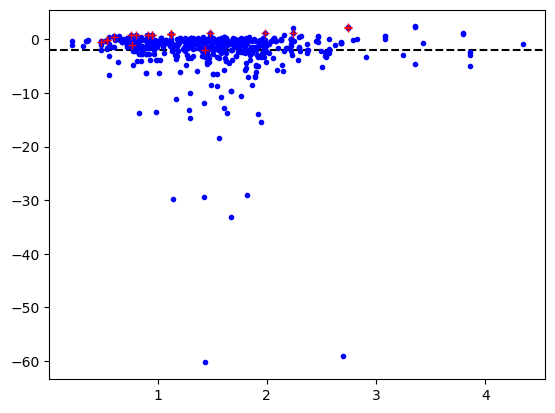

In [14]:
# Plot of residuals

# Values that origionaly fell outside the window and were re-assigned to the 
# largest peak inside the window are called 're-windowed' and are plotted in red.

re_window = resultsDF.loc[resultsDF['old_lag'].notna()]

fig, ax = plt.subplots()
x1=re_window['celerity']
y1=re_window['avg_val_c']
x=resultsDF['celerity']
y=resultsDF['avg_val_c']
ax.axhline(np.mean(y-x), color='k', linestyle='--')
ax.plot(y,  y-x, 'b.', label="differences")
ax.plot(y1, y1-x1, 'r+', label="re-windowed")
ax.set_yscale('linear')

print(f"Mean difference: {np.mean(y-x)}")
print(f"Mean difference for re-windowed: {np.mean(y1-x1)}")

In [15]:
resultsDF[resultsDF['val_count']==0].shape

(326, 23)

## Save Final results to file & Record session

file for the results: "analysis-data-tag-name-.json"

file for parameters of analysis: "analysis-parameters.json"

In [16]:
# Save Session Information
analysis_stop_time = pd.Timestamp.now(tz='UTC')
parameters['analysis_stop'] = analysis_stop_time.strftime('%Y-%m-%dT%H:%M:%SZ')
runtime = (analysis_stop_time - analysis_start_time)
parameters['analysis_runtime'] = str(runtime)
# This name is really long...
parameters['analysis_filename'] = f"xcorr-out-{analysis_tag}-{analysis_stop_time.strftime('%Y-%m-%dT%H')}.json"

# Retrieve old session table and add new line
try:
    old_sessions = pd.read_json('session-parameters.json', orient='table')
except OSError as e:
    old_sessions = pd.DataFrame(columns = parameters.keys())
    old_sessions = old_sessions.astype({'analysis_levels': 'object', 'analysis_search_window': 'object'})

new_sessions = old_sessions._append(parameters, ignore_index=True)    
new_sessions.to_json('session-parameters.json', orient='table')

# Quick read to test
pd.read_json('session-parameters.json', orient='table')

,analysis_tag,analysis_start,analysis_stop,analysis_runtime,analysis_filename,analysis_plotting,analysis_data_source,analysis_data_source_label,analysis_missing,analysis_transform,analysis_filter_type,analysis_filter_cutoff,analysis_levels,analysis_search_window,analysis_detrend
0,depth,2025-06-28T21:03:33Z,2025-06-28T21:03:52Z,0 days 00:00:19.107943,xcorr-out-depth-2025-06-28T21.json,False,WBdata-depth.parquet,Depth (m),full,no_transform,NaN,NaN,"[0, 1, 2, 3, 4, 5, 6, 7]",full,False
1,depth-900,2025-06-28T21:03:59Z,2025-06-28T21:04:18Z,0 days 00:00:18.689082,xcorr-out-depth-900-2025-06-28T21.json,False,WBdata-depth.parquet,Depth (m),full,no_transform,NaN,NaN,"[0, 1, 2, 3, 4, 5, 6, 7]",900,False
2,depth-dt,2025-06-28T21:04:26Z,2025-06-28T21:04:46Z,0 days 00:00:19.631976,xcorr-out-depth-dt-2025-06-28T21.json,False,WBdata-depth.parquet,Depth (m),full,no_transform,NaN,NaN,"[0, 1, 2, 3, 4, 5, 6, 7]",full,True
3,depth-dt-900,2025-06-28T21:04:53Z,2025-06-28T21:05:13Z,0 days 00:00:19.932100,xcorr-out-depth-dt-900-2025-06-28T21.json,False,WBdata-depth.parquet,Depth (m),full,no_transform,NaN,NaN,"[0, 1, 2, 3, 4, 5, 6, 7]",900,True
4,discharge,2025-06-28T21:05:21Z,2025-06-28T21:05:41Z,0 days 00:00:19.551623,xcorr-out-discharge-2025-06-28T21.json,False,WBdata-discharge.parquet,Discharge (m³/s),full,no_transform,NaN,NaN,"[0, 1, 2, 3, 4, 5, 6, 7]",full,False
5,discharge-900,2025-06-28T21:05:49Z,2025-06-28T21:06:08Z,0 days 00:00:19.276503,xcorr-out-discharge-900-2025-06-28T21.json,False,WBdata-discharge.parquet,Discharge (m³/s),full,no_transform,NaN,NaN,"[0, 1, 2, 3, 4, 5, 6, 7]",900,False
6,discharge-dt,2025-06-28T21:06:16Z,2025-06-28T21:06:37Z,0 days 00:00:20.753243,xcorr-out-discharge-dt-2025-06-28T21.json,False,WBdata-discharge.parquet,Discharge (m³/s),full,no_transform,NaN,NaN,"[0, 1, 2, 3, 4, 5, 6, 7]",full,True
7,discharge-dt-900,2025-06-28T21:06:45Z,2025-06-28T21:07:04Z,0 days 00:00:19.806283,xcorr-out-discharge-dt-900-2025-06-28T21.json,False,WBdata-discharge.parquet,Discharge (m³/s),full,no_transform,NaN,NaN,"[0, 1, 2, 3, 4, 5, 6, 7]",900,True
8,band1d130m,2025-06-28T21:07:13Z,2025-06-28T21:07:31Z,0 days 00:00:18.767838,xcorr-out-band1d130m-2025-06-28T21.json,False,WBdata-depth.parquet,Depth (m),full,filter,bandpass,"[1 day, 130 minutes]","[0, 1, 2, 3, 4, 5, 6, 7]",full,False
9,band1d130m-900,2025-06-28T21:07:39Z,2025-06-28T21:07:58Z,0 days 00:00:19.202563,xcorr-out-band1d130m-900-2025-06-28T21.json,False,WBdata-depth.parquet,Depth (m),full,filter,bandpass,"[1 day, 130 minutes]","[0, 1, 2, 3, 4, 5, 6, 7]",900,False


In [17]:
# Save results
resultsDF.to_json(parameters['analysis_filename'], orient='table')
# Read the json file using "orient='table'" to preserve the timestamps.
# The us & ds id's are converted to ints.
# Quick visual check that everything was saved properly
pd.read_json(parameters['analysis_filename'], orient='table')

,us,ds,reach,level,segment,US_nulls,DS_nulls,start,stop,lag,...,raw_us_data_mean,raw_ds_data_mean,comments,old_lag,avg_val_c,avg_val_lag,val_count,resid_c,lag_time,resid_lag
0,01541200,01541303,Curwensville-Hyde,0,0,265,41,2012-10-01 04:00:00+00:00,2016-10-02 03:45:00+00:00,4,...,0.609435,0.618678,,NaN,0.896955,17400.000000,93,2.723600,3600,-13800.000000
1,01541303,01542500,Hyde-Karthaus,0,0,41,5,2012-10-01 04:00:00+00:00,2016-10-02 03:45:00+00:00,30,...,0.618678,0.880297,,NaN,1.625949,49586.746988,83,1.029607,27000,-22586.746988
2,01542500,01545500,Karthaus-Renovo,0,0,5,56,2012-10-01 04:00:00+00:00,2016-10-02 03:45:00+00:00,16,...,0.880297,1.143322,,NaN,1.836387,35032.978723,94,2.019446,14400,-20632.978723
3,01545500,01551500,Renovo-Williamsport,0,0,56,50,2012-10-01 04:00:00+00:00,2016-10-02 03:45:00+00:00,35,...,1.143322,1.492794,,NaN,1.587171,67700.000000,81,1.389718,31500,-36200.000000
4,01541200,01541303,Curwensville-Hyde,1,0,223,22,2012-10-01 04:00:00+00:00,2014-10-02 03:45:00+00:00,4,...,0.645802,0.625568,,NaN,0.920016,17162.068966,29,2.700539,3600,-13562.068966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,01545500,01551500,Renovo-Williamsport,7,123,0,0,2016-08-06 02:00:00+00:00,2016-08-17 11:45:00+00:00,102,...,0.509027,0.642220,,NaN,NaN,NaN,0,NaN,91800,NaN
1016,01545500,01551500,Renovo-Williamsport,7,124,0,0,2016-08-17 12:00:00+00:00,2016-08-28 21:45:00+00:00,363,...,0.519515,0.711295,Lag was -699.,-699.0,NaN,NaN,0,NaN,326700,NaN
1017,01545500,01551500,Renovo-Williamsport,7,125,0,0,2016-08-28 22:00:00+00:00,2016-09-09 07:45:00+00:00,141,...,0.499797,0.600096,,NaN,0.755008,124200.000000,2,-0.016064,126900,2700.000000
1018,01545500,01551500,Renovo-Williamsport,7,126,0,0,2016-09-09 08:00:00+00:00,2016-09-20 17:45:00+00:00,139,...,0.489310,0.586742,,NaN,0.694607,135000.000000,1,0.054969,125100,-9900.000000


## Assert Nulls & Validation Count are correct

Check that the calculations of how many nulls are in the data set are correct, and
check that the correct number of validation observations are in the dataset.

In [18]:
# Check output: amount of missing values (nulls)
# Depth data should show 367 US_nulls and 152 DS_nulls per level and 2936 US_nulls and 1216 DS_nulls for all 8 levels
# Discharge  should show 32062 & 44001 for a single level and 256496 & 352008 for all 8 levels
if analysis_data_source == "WBdata-depth.parquet":
    us = 367
    ds = 152
elif analysis_data_source == "WBdata-discharge.parquet":
    us = 32062
    ds = 44001
elif analysis_data_source == "WBdata-discharge_daily.parquet":
    us = 0
    ds = 0
else:
    print(f"Data source is not recognized. Source: {analysis_data_source}")
    us = 999
    ds = 999

def test_nulls(row, us_nulls, ds_nulls):
    assert row.US_nulls == us_nulls, f"Expected {us_nulls}, but got {row.US_nulls}."
    assert row.DS_nulls == ds_nulls, f"Expected {ds_nulls}, but got {row.DS_nulls}."
    return f"Correct number of nulls. US:{us_nulls}   DS:{ds_nulls}"

print(f"Each level of the analysis should have a total of {us} nulls upstream and {ds} nulls downstream")
resultsDF.groupby(['level'])[['US_nulls', 'DS_nulls']].sum().apply(test_nulls, args=(us,ds), axis=1)

Each level of the analysis should have a total of 367 nulls upstream and 152 nulls downstream


level
0    Correct number of nulls. US:367   DS:152
1    Correct number of nulls. US:367   DS:152
2    Correct number of nulls. US:367   DS:152
3    Correct number of nulls. US:367   DS:152
4    Correct number of nulls. US:367   DS:152
5    Correct number of nulls. US:367   DS:152
6    Correct number of nulls. US:367   DS:152
7    Correct number of nulls. US:367   DS:152
dtype: object

In [19]:
# Check output: validation data count
# There should be 93, 83, 94, 81 = 351 validation observations in each level.
def test_v_obs(row):
     #print(row)
    Level, Reach = row.name
    if Reach == 'Curwensville-Hyde':
        v_count = 93
    elif Reach == 'Hyde-Karthaus':
        v_count = 83
    elif Reach == 'Karthaus-Renovo':
        v_count = 94
    elif Reach == 'Renovo-Williamsport':
        v_count = 81
    #assert row.val_count == v_count, f"Was expecting {Level}-{Reach} val_count to equal {v_count} observations, but got {row.val_count}."
    return f"{row.val_count}"# is good"

print("There should be 93, 83, 94, 81 = 351 validation observations in each level.")
(resultsDF.groupby(['level', 'reach'])[['US_nulls','DS_nulls','val_count']]
     .sum()
     .apply(test_v_obs, axis=1)
     .unstack('reach')
)

There should be 93, 83, 94, 81 = 351 validation observations in each level.


reach,Curwensville-Hyde,Hyde-Karthaus,Karthaus-Renovo,Renovo-Williamsport
level,,,,
0,93,83,94,81
1,93,83,94,81
2,93,83,94,81
3,93,83,94,81
4,93,83,94,81
5,93,83,94,81
6,93,83,94,81
7,93,83,94,81


# Evaluation of Results

## View the Results

In [20]:
resultsDF.describe()

,level,segment,US_nulls,DS_nulls,lag,xcorr,xwidth,celerity,raw_us_data_mean,raw_ds_data_mean,old_lag,avg_val_c,avg_val_lag,val_count,resid_c,lag_time,resid_lag
count,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,838.000000,1020.000000,1020.000000,111.000000,694.000000,694.000000,1020.000000,595.000000,1.020000e+03,6.940000e+02
mean,6.031373,42.333333,2.878431,1.192157,55.094118,0.876696,143.609804,3.368120,0.812932,1.033779,-207.711712,1.471337,42762.887047,2.752941,1.947047,4.958471e+04,3.250200e+01
std,1.322781,36.048526,17.268387,4.522579,149.395094,0.155380,44.618574,5.245845,0.381564,0.528215,387.289283,0.643989,24650.295972,7.582438,4.792627,1.344556e+05,1.354151e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.117048,1.000000,0.009018,0.179495,0.214097,-2148.000000,0.212974,6300.000000,0.000000,-2.405122,0.000000e+00,-7.740000e+04
25%,6.000000,12.000000,0.000000,0.000000,6.000000,0.843826,121.750000,1.206852,0.538783,0.645170,-282.500000,0.948413,22286.250000,0.000000,0.180918,5.400000e+03,-2.767500e+04
50%,7.000000,32.000000,0.000000,0.000000,23.000000,0.937284,142.000000,2.212963,0.726557,0.943378,-20.000000,1.450371,39600.000000,1.000000,0.877710,2.070000e+04,-1.620000e+04
75%,7.000000,64.000000,1.000000,0.000000,45.000000,0.976288,165.000000,3.592797,1.032820,1.337995,-6.000000,1.810606,55800.000000,2.000000,2.092932,4.050000e+04,-7.200000e+03
max,7.000000,127.000000,265.000000,56.000000,1606.000000,0.999091,432.000000,61.693333,2.797250,3.704354,-1.000000,4.341296,153900.000000,94.000000,60.258605,1.445400e+06,1.424250e+06


In [21]:
print(resultsDF.shape)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(resultsDF)

(1020, 23)


,us,ds,reach,level,segment,US_nulls,DS_nulls,start,stop,lag,xcorr,xwidth,celerity,raw_us_data_mean,raw_ds_data_mean,comments,old_lag,avg_val_c,avg_val_lag,val_count,resid_c,lag_time,resid_lag
0,01541200,01541303,Curwensville-Hyde,0,0,265,41,2012-10-01 04:00:00+00:00,2016-10-02 03:45:00+00:00,4,0.892005,119,3.620556,0.609435,0.618678,,NaN,0.896955,17400.000000,93,2.723600,3600,-1.380000e+04
1,01541303,01542500,Hyde-Karthaus,0,0,41,5,2012-10-01 04:00:00+00:00,2016-10-02 03:45:00+00:00,30,0.863660,146,2.655556,0.618678,0.880297,,NaN,1.625949,49586.746988,83,1.029607,27000,-2.258675e+04
2,01542500,01545500,Karthaus-Renovo,0,0,5,56,2012-10-01 04:00:00+00:00,2016-10-02 03:45:00+00:00,16,0.901117,132,3.855833,0.880297,1.143322,,NaN,1.836387,35032.978723,94,2.019446,14400,-2.063298e+04
3,01545500,01551500,Renovo-Williamsport,0,0,56,50,2012-10-01 04:00:00+00:00,2016-10-02 03:45:00+00:00,35,0.907372,154,2.976889,1.143322,1.492794,,NaN,1.587171,67700.000000,81,1.389718,31500,-3.620000e+04
4,01541200,01541303,Curwensville-Hyde,1,0,223,22,2012-10-01 04:00:00+00:00,2014-10-02 03:45:00+00:00,4,0.878540,118,3.620556,0.645802,0.625568,,NaN,0.920016,17162.068966,29,2.700539,3600,-1.356207e+04
5,01541200,01541303,Curwensville-Hyde,1,1,42,19,2014-10-02 04:00:00+00:00,2016-10-02 03:45:00+00:00,6,0.909300,121,2.413704,0.573161,0.611788,,NaN,0.886506,17507.812500,64,1.527198,5400,-1.210781e+04
6,01541303,01542500,Hyde-Karthaus,1,0,22,4,2012-10-01 04:00:00+00:00,2014-10-02 03:45:00+00:00,31,0.874984,146,2.569892,0.625568,0.887357,,NaN,1.610660,48030.000000,30,0.959233,27900,-2.013000e+04
7,01541303,01542500,Hyde-Karthaus,1,1,19,1,2014-10-02 04:00:00+00:00,2016-10-02 03:45:00+00:00,29,0.851277,146,2.747126,0.611788,0.873237,,NaN,1.634603,50467.924528,53,1.112523,26100,-2.436792e+04
8,01542500,01545500,Karthaus-Renovo,1,0,4,31,2012-10-01 04:00:00+00:00,2014-10-02 03:45:00+00:00,16,0.903957,131,3.855833,0.887357,1.156715,,NaN,1.834687,34527.272727,33,2.021147,14400,-2.012727e+04
9,01542500,01545500,Karthaus-Renovo,1,1,1,25,2014-10-02 04:00:00+00:00,2016-10-02 03:45:00+00:00,15,0.896946,134,4.112889,0.873237,1.129930,,NaN,1.837308,35306.557377,61,2.275581,13500,-2.180656e+04
